# Building Code Documentation Agents with CrewAI

[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2qNXgLMuzlJ8LS8Kl30EXbGwxSh)

This notebook demonstrates how to create a crew of multiple Agents for writing documentation using CrewAI Flows.
The crew will analyze code from any public GitHub repository and generate comprehensive documentation
by working collaboratively using specialized agents with different roles and responsibilities.
CrewAI Flows enable coordinated execution and communication between agents to produce high-quality
documentation for any codebase.

You will use NVIDIA NIM Microservices for the LLM, llama 3.3 70B. In addition, NeMo Retriever E5 embedding NIM, is used. 

You can get started by leveraging NVIDIA API Catalog and call a hosted model's NIM API Endpoint. Once you familiarize yourself with this blueprint, you may want to self-host models with NVIDIA NIM Microservices.

Here's an architecture diagram of the workflow.
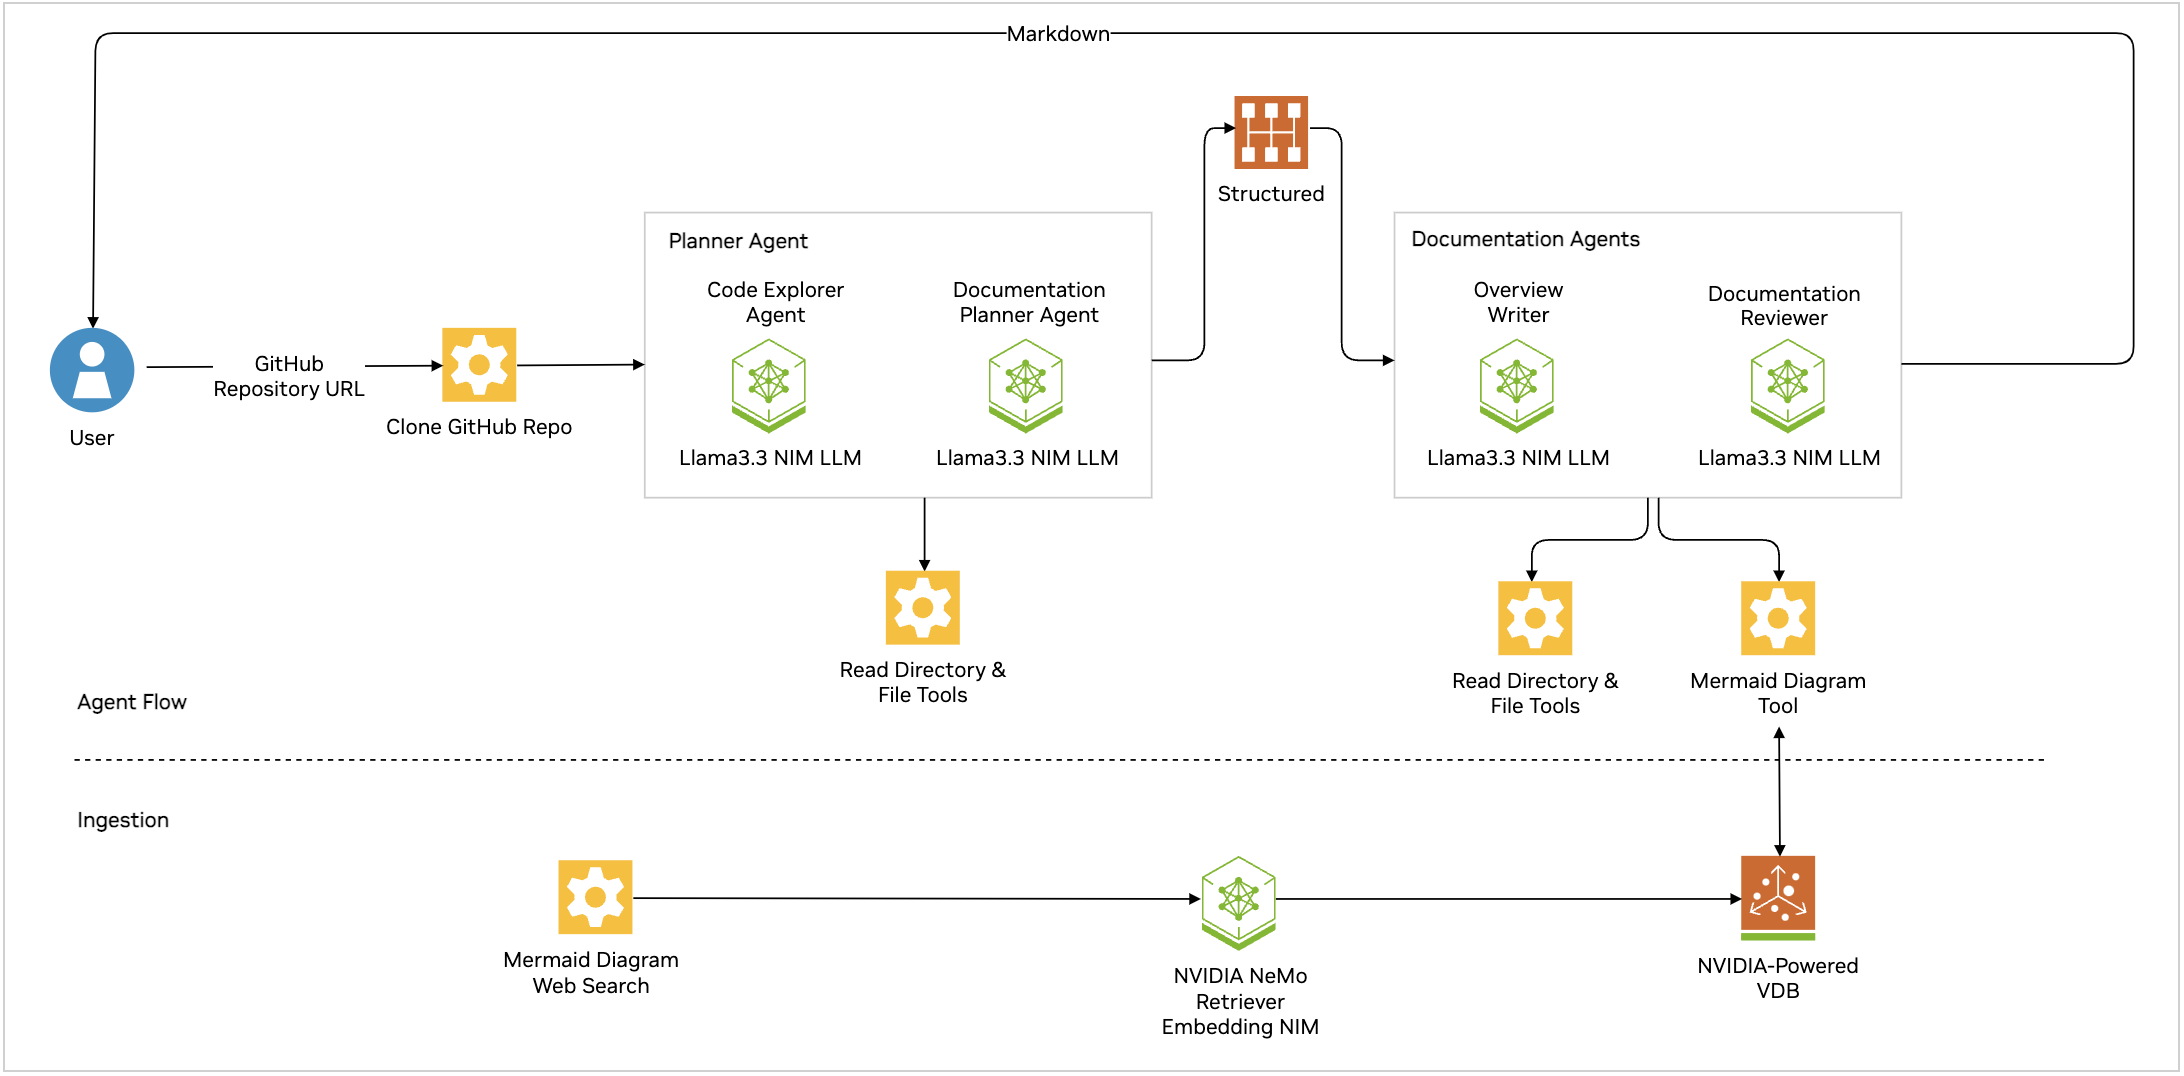

The system employs a multi-agent workflow divided into two key stages:
1. Codebase Analysis and Strategy Planning:
    - Analyze Codebase: Planner agents inspect the repository to map its structure, identify key components, and understand interdependencies.
    - Develop Strategy: They create a tailored documentation plan based on the analysis.
2. Documentation Creation and Review:
    - High-Level Documentation: One agent generates clear, comprehensive documentation introducing the project and its architecture.
    - Quality Assurance: Another agent ensures accuracy, consistency, and completeness across all documentation.



# Content Overview
>[Prerequisites](#Prerequisites)  
>[Define the project URL](#Define-the-project-URL)  
>[Create Planning Crew](#Create-Planning-Crew)  
>[Create Documentation Crew](#Create-Documentation-Crew)  
>[Run Documentation Flow](#Run-Documentation-Flow)  
________________________


## Prerequisites 
### Install Dependencies

In [ ]:
# Install required packages
%pip install "crewai[tools]==0.86.0" tqdm==4.67.1 langchain_nvidia_ai_endpoints==0.3.7

### Initialization and Setup
Initial imports for the CrewAI Flow and Crew and setting up the environment

In [2]:
# Importing necessary libraries
import os
import yaml
import subprocess
from pathlib import Path
from pydantic import BaseModel

# Importing Crew related components
from crewai import Agent, Task, Crew

# Importing CrewAI Flow related components
from crewai.flow.flow import Flow, listen, start

# Apply a patch to allow nested asyncio loops in Jupyter
import nest_asyncio
nest_asyncio.apply()

## API Keys
Prior to getting started, you will need to create API Keys for the NVIDIA API Catalog.

- NVIDIA API Catalog
  1. Navigate to **[NVIDIA API Catalog](https://build.nvidia.com/explore/discover)**.
  2. Select any model, such as llama-3.3-70b-instruct.
  3. On the right panel above the sample code snippet, click on "Get API Key". This will prompt you to log in if you have not already.

### Export API Keys

Save this API Key as environment variables.


In [3]:
import getpass
import os

if not os.environ.get("NVIDIA_NIM_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_NIM_API_KEY"] = nvapi_key
    os.environ["NVIDIA_API_KEY"] = nvapi_key

### Working with the NVIDIA API Catalog
Let's test the API endpoint. The NVIDIA NIM Microservices used in this notebook are llama-3.3-70b and an NVIDIA text embedding model, nv-embedqa-e5-v5. These are models are defined in the yaml files in the `config` directory if you're looking for them!

In [ ]:
from litellm import completion

response = completion(
    model="nvidia_nim/meta/llama-3.3-70b-instruct",
    messages=[
        {
            "role": "user",
            "content": "What's a good name for a dog?",
        }
    ]
)

print(response)

### Optional: Locally Run NVIDIA NIM Microservices

Once you familiarize yourself with this blueprint, you may want to self-host models with NVIDIA NIM Microservices using NVIDIA AI Enterprise software license. This gives you the ability to run models anywhere, giving you ownership of your customizations and full control of your intellectual property (IP) and AI applications.

[Learn more about NIM Microservices](https://developer.nvidia.com/blog/nvidia-nim-offers-optimized-inference-microservices-for-deploying-ai-models-at-scale/)

<div class="alert alert-block alert-success">
<b>NOTE:</b> Run the following cell only if you're using a local NIM Microservice instead of the API Catalog Endpoint.
</div>

In [5]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

# connect to an embedding NIM running at localhost:8000, specifying a model
llm = ChatNVIDIA(base_url="http://localhost:8000/v1", model="meta/llama-3.3-70b-instruct")

## Define the project URL

In this demo, a sample repository is provided for you. However, feel fry to test this on other public repositories! 

In [11]:
project_url = "https://github.com/crewAIInc/nvidia-demo"

## Plan for our Flow

1. Clone the repository for the project
2. Plan the documentation for the project **[Crew of Agents]** 
3. Create the documentation for the project **[Crew of Agents]**

# ![CrewAIFlow.png](crewai-nim-flow.png)

## Create Planning Crew

Initial strucutre data we will use to capture the output of the planning crew

In [12]:
# Define data structures to capture documentation planning output
class DocItem(BaseModel):
    """Represents a documentation item"""
    title: str
    description: str
    prerequisites: str
    examples: list[str]
    goal: str

class DocPlan(BaseModel):
    """Documentation plan"""
    overview: str
    docs: list[DocItem]

Optimizing for Llama 3.3 Prompting Template

In [13]:
# Agents Prompting Template for Llama 3.3
system_template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>{{ .System }}<|eot_id|>"""
prompt_template="""<|start_header_id|>user<|end_header_id|>{{ .Prompt }}<|eot_id|>"""
response_template="""<|start_header_id|>assistant<|end_header_id|>{{ .Response }}<|eot_id|>"""

Create the crew

In [ ]:
from crewai_tools import (
    DirectoryReadTool,
    FileReadTool,
)

# Load agent and task configurations from YAML files
with open('config/planner_agents.yaml', 'r') as f:
    agents_config = yaml.safe_load(f)

with open('config/planner_tasks.yaml', 'r') as f:
    tasks_config = yaml.safe_load(f)

code_explorer = Agent(
  config=agents_config['code_explorer'],
  system_template=system_template,
  prompt_template=prompt_template,
  response_template=response_template,
  tools=[
    DirectoryReadTool(),
    FileReadTool()
  ]
)
documentation_planner = Agent(
  config=agents_config['documentation_planner'],
  system_template=system_template,
  prompt_template=prompt_template,
  response_template=response_template,
  tools=[
    DirectoryReadTool(),
    FileReadTool()
  ]
)

analyze_codebase = Task(
  config=tasks_config['analyze_codebase'],
  agent=code_explorer
)
create_documentation_plan = Task(
  config=tasks_config['create_documentation_plan'],
  agent=documentation_planner,
  output_pydantic=DocPlan
)

planning_crew = Crew(
    agents=[code_explorer, documentation_planner],
    tasks=[analyze_codebase, create_documentation_plan],
    verbose=False
)

## Create Documentation Crew

Crew of AI Agents to execute the documentation plan and create the documentation

Tools for the documentation crew

In [15]:
from typing import Type
from crewai_tools import BaseTool
from pydantic import BaseModel, Field

class ValidateMermaidInput(BaseModel):
    """Input schema for ValidateMermaidTool."""
    text: str = Field(..., description="Mermaid diagram text to validate.")

class ValidateMermaidTool(BaseTool):
    name: str = "Validate Mermaid Diagram"
    description: str = (
        "Validates Mermaid diagram syntax, specifically checking for proper arrow syntax "
        "and ensuring there are no invalid trailing '>' characters or malformed pipe ('|') decorators."
    )
    args_schema: Type[BaseModel] = ValidateMermaidInput

    def _run(self, text: str) -> bool:
        # Check for invalid trailing > in arrow syntax
        if "|>" in text:
            return False

        # Check for valid arrow syntax
        valid_arrows = ["-->", "---", "---|", "|---|"]
        lines = text.split("\n")
        for line in lines:
            if any(arrow in line for arrow in valid_arrows):
                # Verify arrow syntax is properly formatted
                parts = line.split()
                for part in parts:
                    if part.startswith("|") and not part.endswith("|"):
                        return False
                    if part.endswith(">") and not part.startswith("-"):
                        return False

        return True

Create the Crew

In [ ]:
from crewai_tools import (
    DirectoryReadTool,
    FileReadTool,
    WebsiteSearchTool
)

# Load agent and task configurations from YAML files
with open('config/documentation_agents.yaml', 'r') as f:
    agents_config = yaml.safe_load(f)

with open('config/documentation_tasks.yaml', 'r') as f:
    tasks_config = yaml.safe_load(f)

overview_writer = Agent(config=agents_config['overview_writer'], tools=[
    DirectoryReadTool(),
    FileReadTool(),
    ValidateMermaidTool(),
    WebsiteSearchTool(
      website="https://mermaid.js.org/syntax/examples.html",
      config=dict(
        embedder=dict(
            provider="nvidia",
            config=dict(
                model="nvidia/nv-embedqa-e5-v5"
            ),
        ),
      )
    )
])

documentation_reviewer = Agent(config=agents_config['documentation_reviewer'], tools=[
    DirectoryReadTool(directory="docs/", name="Check existing documentation folder"),
    ValidateMermaidTool(),
    FileReadTool(),
])

draft_documentation = Task(
  config=tasks_config['draft_documentation'],
  agent=overview_writer
)

qa_review_documentation = Task(
  config=tasks_config['qa_review_documentation'],
  agent=documentation_reviewer
)

documentation_crew = Crew(
    agents=[overview_writer, documentation_reviewer],
    tasks=[draft_documentation, qa_review_documentation],
    verbose=False
)

## Create Documentation Flow

A Flow to create the documentation for the project where we will use the planning crew to plan the documentation and the documentation crew to create the documentation

In [17]:
class DocumentationState(BaseModel):
  """
  State for the documentation flow
  """
  project_url: str = project_url
  repo_path: Path = "workdir/"

class CreateDocumentationFlow(Flow[DocumentationState]):
  # Clone the repository, initial step
  # No need for AI Agents on this step, so we just use regular Python code
  @start()
  def clone_repo(self):
    print(f"# Cloning repository: {self.state.project_url}")
    # Extract repo name from URL
    repo_name = self.state.project_url.split("/")[-1]
    self.state.repo_path = f"{self.state.repo_path}{repo_name}"

  # Check if directory exists
    if Path(self.state.repo_path).exists():
      print(f"# Repository directory already exists at {self.state.repo_path}")
      subprocess.run(["rm", "-rf", self.state.repo_path])
      print("# Removed existing directory")

    # Clone the repository
    subprocess.run(["git", "clone", self.state.project_url, self.state.repo_path])
    return self.state

  @listen(clone_repo)
  def plan_docs(self):
    print(f"# Planning documentation for: {self.state.repo_path}")
    result = planning_crew.kickoff(inputs={'repo_path': self.state.repo_path})
    print(f"# Planned docs for {self.state.repo_path}:")
    for doc in result.pydantic.docs:
        print(f"    - {doc.title}")
    return result

  @listen(plan_docs)
  def save_plan(self, plan):
    with open("docs/plan.json", "w") as f:
      f.write(plan.raw)

  @listen(plan_docs)
  def create_docs(self, plan):
    for doc in plan.pydantic.docs:
      print(f"# Creating documentation for: {doc.title}")
      result = documentation_crew.kickoff(inputs={
        'repo_path': self.state.repo_path,
        'title': doc.title,
        'overview': plan.pydantic.overview,
        'description': doc.description,
        'prerequisites': doc.prerequisites,
        'examples': doc.examples,
        'goal': doc.goal
      })

      # Save documentation to file in docs folder
      docs_dir = Path("docs")
      docs_dir.mkdir(exist_ok=True)
      title = doc.title.lower().replace(" ", "_") + ".mdx"
      with open(docs_dir / title, "w") as f:
          f.write(result.raw)
    print(f"# Documentation created for: {self.state.repo_path}")

Implementing helper methods to plot and execute the flow in a Jupyter notebook

In [ ]:
# Plot the flow
flow = CreateDocumentationFlow()
flow.plot()

# Display the flow visualization using IFrame
from IPython.display import IFrame

# Display the flow visualization
IFrame(src='./crewai_flow.html', width='100%', height=400)

## Run Documentation Flow

After running this cell, check the `docs` directory for the generated documentation. 

In [ ]:
flow = CreateDocumentationFlow()
flow.kickoff()